In [1]:
#main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#feature manipulation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score,\
recall_score, precision_recall_curve, average_precision_score, accuracy_score, f1_score

#other
import time
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

# Table of Contents

1. Introduction
2. Day 1 Churn Prediction
    1. Setup
    1. Heatmap
        1. Findings
    2. Logistic Regression
        1. Model 
        2. Feature Coefficients 
    3. Decision Tree
        1. Setup 
        2. Model 
    3. Random Forests
        2. Model
    4. K-Nearest Neighbors
        1. Model 
    5. Principal Component Analysis
        1. K-Nearest Neighbours
        2. Logistic Regression 
        3. Random Forests
    5. Evaluation and Tuning
        2. Precision-Recall Curve
        3. Conclusion

2. Understandting Churn
    1. Correlation
    2. Lasso Regression
    3. Conclusion

6. Future Improvements

# Introduction

This section builds on the previous ['Cleaning, Wrangling and Feature Engineering' notebook](./Cleaning%2C%20Wrangling%20and%20Feature%20Engineering.ipynb) by applying, evaluating and testing on pre-processed features. There are 2 main aims for this section; 

1. Achieve highest precision for predicting churn on day 1. Compare multiple models with initial features, then with principal components. Our aim is to improve retention by predicting churn before it happens. We hope to achieve this by automating a personalised push notification process to users who are likely to churn.

2. Apply feature selection to obtain actionable insights by understanding churn. These insights will guide us through strategising future acquisition campaigns and product development roadmap. 


Logistic Regression, Random Forests and K-Nearest Neighbors performances are evulated for predicting churn on day 1. Principal Component Analysis is applied for improving K-Nearest Neighbors performance. Models are compared by using precision-recall curve, Random Forests outperforming the rest.

# Day 1 Churn Prediction

## Setup

Reading people and people_raw dataframes from Cleaning, Wrangling and Feature Engineering notebooks. 

In [2]:
people_raw = pd.read_csv('people_raw.csv')
people_raw.index = people_raw['Unnamed: 0']
people_raw = people_raw.drop('Unnamed: 0', axis=1)
del people_raw.index.name
# people_raw.head(1) CONFIDENTIAL

,$distinct_id,Device ID,$ios_device_model,$city,$last_seen,$timezone,Email,$notifications,$country_code,Number of Sessions,...,$ios_ifa,$distinct_id.1,Full Name,$region,$predict_grade,signup_date,$app_release,distinct_id,duration,churn
0,BF616D19-537B-4FC6-9D0E-633B6D61C02F,BF616D19-537B-4FC6-9D0E-633B6D61C02F,"iPhone7,2",Istanbul,2016-02-10 00:00:00,Europe/Istanbul,NaN,NaN,TR,24,...,NaN,NaN,NaN,Istanbul,converted,2015-09-04 11:22:29,1.0,BF616D19-537B-4FC6-9D0E-633B6D61C02F,159,0


In [3]:
people = pd.read_csv('people.csv')
people.index = people['Unnamed: 0']
people = people.drop('Unnamed: 0', axis=1)
del people.index.name
people.head(2)

,city,country_code,registered,app_release,churn,recent_device,recent_version,acquisition_cohort
0,istanbul,TR,0,other,0,0,0,broad
1,istanbul,TR,0,other,1,0,0,broad


App release and acquisition cohort are related to the date that a user has signed up. For example, A new user acquired Today will never have the app_release from a year ago. Including these columns might improve my cross validation scores, however, prediction accuracy on new users will be lower. Therefore, I will exclude both columns from my models for now.  

In [4]:
print 'baseline accuracy: ' + str(len(people[people.churn == 0]) / float(len(people)))
#balanced reponse variable results in baseline near 60%

baseline accuracy: 0.607220134381


Drop date related columns and get dummies for categorical features. 

In [5]:
y = people.churn#target variable
X = people.drop(['app_release','acquisition_cohort','churn'], axis=1)#drop time scale columns
X = pd.get_dummies(X, columns=['city','country_code'], drop_first=True)#get dummies

In [6]:
print 'features shape: ' + str(X.shape)
print 'target shape: ' + str(y.shape)

features shape: (8781, 14)
target shape: (8781,)


Not using Standard Scaler since all my feature variables are boolean. 

## Heatmap

In [7]:
def corr_heatmap(data, width, height):
    data_corr = data.corr()

    mask = np.zeros_like(data_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=(width,height))
    ax = sns.heatmap(data_corr, mask=mask)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()

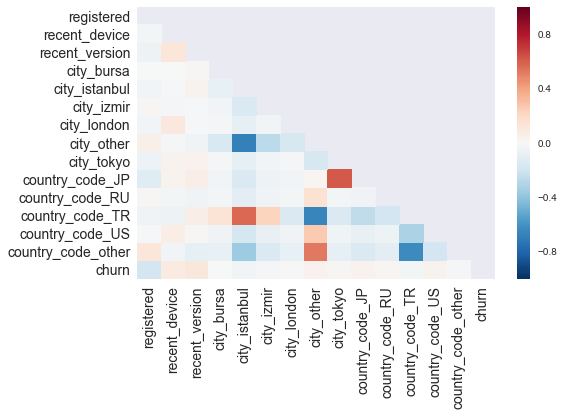

In [8]:
h_data = X.copy()
h_data['churn'] = y
corr_heatmap(h_data, 8, 5)

1. There are highly correlated cities and countries, which was expected. Also, there is an inverse correlation of other city/countries to Turkey/Istanbul.
2. None of the features have high correlation to target variable, I am not expecting a major improvement on the baseline. 

Lets inspect how our features correlate with the target variable. 

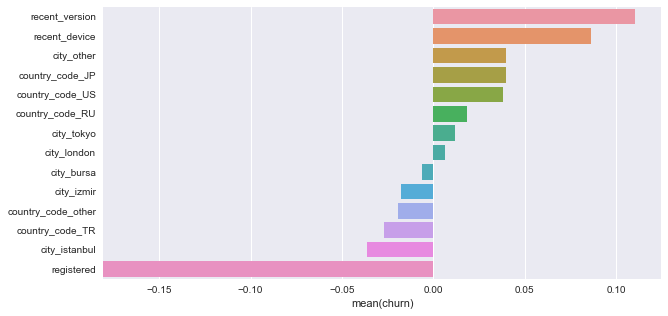

In [9]:
churn_corr = h_data.corr()['churn'].drop('churn').sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=churn_corr, y=churn_corr.index)

##### Findings:

1. A user that has the most recent device and an updated iOS version is correlated with higher churn. Someone that is tech-savvy is more likely to download many apps, thus have less tolerance for each app he/she tries. 
2. Registration is a time investment and an indication of trust, therefore high inverse correlation with churn is not suprising. It is also possible that a user who downloads the app through word of mouth is more likely to register, due to higher trust. 
3. Turkey looks like a good target for launching more acquisition campaigns. 



I will create a dataframe that will keep all the performance metrics of models, this is to keep information retained over various sections, and making it easier to read. 

In [10]:
results = pd.DataFrame(columns=['model','precision','recall','accuracy'])

baseline_acc = len(people[people.churn == 0]) / float(len(people))
results.loc[0,:] = ['baseline', np.nan, np.nan, baseline_acc]

results

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722


I will be using gridsearchcv for model optimisation. Since the final action of predicted values is to send push notifications to users that are likely to churn, predicting 1's with optimum precision is the end goal. Optimising all the models for precision is a way to keep push notifications risk free. Sending a push notification to a user that is not going to churn may actually cause churn. Therefore, it is acceptable to predict a small proportion of users who will churn (recall), but make sure predictions are made with high confidence (precision). I will be optimising gridsearch for precision scoring.  

## Logistic Regression

### Model

1. Gridsearch logistic regression over various regularization strengths and penalty of Lasso or Ridge. 
2. 5 fold cross validation, optimised for precision. 
3. Fit model and print best parameters, best precision score. 
4. Iterate process by refining parameter search space to find optimum values. 

In [11]:
def gridsearch_lr_model(params, X=X):
    
    start = time.time()#start timer
    model = LogisticRegression(random_state=42)#set model 
    lr_grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='precision')#gridsearch with 8 fold cross validation 
    lr_grid = lr_grid.fit(X, y)#fit regression model    
    end = time.time()#end timer
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", lr_grid.best_params_
    print 'Best precision score: \n', lr_grid.best_score_
    return lr_grid

In [12]:
#Create a dictionary with the gridsearch parameters
params = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
          'penalty': ['l1','l2']}#searching over Lasso and Ridge

lr_grid = gridsearch_lr_model(params)

/Users/aligulez/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model fit time in seconds: 
3.70720100403
Best params: 
{'penalty': 'l2', 'C': 0.01}
Best precision score: 
0.548787446115


Gridsearch picked Ridge regularization, which shows that cross correlation between features were not causing performance decrease. Since the scores are based on cross validated results, regularization strength is quite high. This lowers the variance, thus prevents the model from overfitting. 

In [13]:
params = {'C': np.linspace(0.005,0.015,15),
          'penalty': ['l1','l2']}

lr_grid = gridsearch_lr_model(params)

Model fit time in seconds: 
2.8541829586
Best params: 
{'penalty': 'l2', 'C': 0.0050000000000000001}
Best precision score: 
0.560100131269


In [14]:
def model_scores(model_grid, model_name, X=X, y=y):
    """
    Save and return  cross validated accuracy, precision and 
    recall scores for the input model, for various feature sets. 
    """
    accuracy = cross_val_score(model_grid.best_estimator_, X, y, scoring='accuracy', cv=5)
    precision = cross_val_score(model_grid.best_estimator_, X, y, scoring='precision', cv=5)
    recall = cross_val_score(model_grid.best_estimator_, X, y, scoring='recall', cv=5)

    results.loc[len(results),:] = [model_name, np.mean(precision), np.mean(recall), np.mean(accuracy)]
    return results 

In [15]:
model_scores(lr_grid, 'logistic regression')

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015


Accuracy improvement over the baseline is very small. This was expected since there are various factors causing churn and we are only using a very limited feature set. Improvements on prediction accuracy and precision can be made by engineering and obtaining new features. However, there will still be some factors that we cannot track such as the mood of the person at the time of download, wether they heard about the app through their friends etc.

### Feature Coefficients

In [16]:
coefs_vars = pd.DataFrame({#dataframe for feature coeffs for easy plotting 
    'coef':lr_grid.best_estimator_.coef_[0],#feature coefficients
    'variable':X.columns,#get names of the columns
    'abscoef':np.abs(lr_grid.best_estimator_.coef_[0])#absolute value feature coeffs. 
})

In [17]:
coef_vars = coefs_vars.sort_values('abscoef', ascending=False)#sort by correlation strength 
coef_vars

,abscoef,coef,variable
0,0.566676,-0.566676,registered
2,0.258586,0.258586,recent_version
1,0.219506,0.219506,recent_device
11,0.126435,-0.126435,country_code_TR
4,0.118344,-0.118344,city_istanbul
13,0.111449,-0.111449,country_code_other
5,0.052478,-0.052478,city_izmir
6,0.031327,-0.031327,city_london
10,0.028916,0.028916,country_code_RU
12,0.028056,0.028056,country_code_US


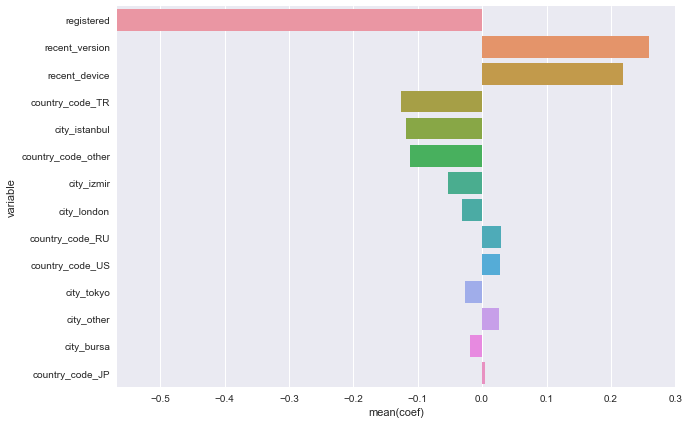

In [18]:
fig = plt.figure(figsize=(10,7))
sns.barplot(x='coef', y='variable', data=coef_vars)

Feature coefficients are very much in line with churn-correlation plot we have observed earlier. Logistic regression is simply taking correlations into account the same way and imposing regularization to improve variance. 

## Decision Trees

I will use Random Forests for higher performance. It is useful to start off with a single decision tree, viusalise the splits and understand how random forests improve precision. 

### Setup

During fit, decision tree goes through different features and values to pick the decision which will split a group of observations that maximises impurity (or information gain). Therefore, decision trees does not assume a linear relation between continous numerical values. I will convert my categorical features to integers through Label Encoder instead of converting to dummy variables.

In [19]:
people.head() #original dataframe 

,city,country_code,registered,app_release,churn,recent_device,recent_version,acquisition_cohort
0,istanbul,TR,0,other,0,0,0,broad
1,istanbul,TR,0,other,1,0,0,broad
2,other,US,1,1.2,1,0,1,producthunt.com
3,other,US,0,1.2,1,0,1,producthunt.com
4,other,US,1,1.2,0,0,0,late_feb_other


In [20]:
X_fac = people.copy()#create new feature set for random forests 

In [21]:
le = LabelEncoder() #label encoder factorises categorical strings to integers
X_fac['city'] = le.fit_transform(people_raw.ix[people.index,'$city'].values)#retrieve raw city strings
X_fac['country_code'] = le.fit_transform(people_raw.ix[people.index,'$country_code'].values)#retrieve raw country strings

In [22]:
X_fac = X_fac.drop(['churn','app_release','acquisition_cohort'], axis=1)#drop target and time-dependant features 

In [23]:
X_fac.head()
#feature set looks ready for decision trees

,city,country_code,registered,recent_device,recent_version
0,650,104,0,0,0
1,650,104,0,0,0
2,1095,107,1,0,1
3,1258,107,0,0,1
4,1301,107,1,0,0


In [24]:
print X_fac.shape, y.shape
#checking the final shapes 

(8781, 5) (8781,)


### Model

1. Gridsearch decision tree over various minimum samples per leaf and maximum tree depth. Both parameters are interrelated to each other. A high depth tree will have relatively lower samples per leaf since there are more decisions the training observations goes through. Very high depth tree (growing very complex) may be overfitting. Decision trees are known to overfit, however, there are solutions to this problem such as Random Forests. 
2. 5 fold cross validation, optimised for precision. 
3. Fit model and print best parameters, best precision score. 
4. Iterate process by refining parameter search space to find optimum values. 

In [25]:
def gridsearch_dt_model(params, X=X_fac):    

    start = time.time()
    dt_model = DecisionTreeClassifier(random_state=42)#init decision tree
    dt_grid = GridSearchCV(estimator=dt_model, param_grid=params, cv=5, scoring='precision')#5fold cv, optimised for precision
    dt_grid = dt_grid.fit(X_fac, y)#fit model    
    end = time.time()
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", dt_grid.best_params_
    print 'Best precision score: \n', dt_grid.best_score_
    return dt_grid

In [26]:
params = {'min_samples_leaf': [1, 5, 10, 100, 1000],
          'max_depth': [1, 10, 100, 1000]}

dt_model = gridsearch_dt_model(params)

Model fit time in seconds: 
1.47891688347
Best params: 
{'max_depth': 10, 'min_samples_leaf': 100}
Best precision score: 
0.51760117739


In [27]:
params = {'min_samples_leaf': range(10, 1000, 100),
          'max_depth': range(1, 100, 10)}

dt_model = gridsearch_dt_model(params)

Model fit time in seconds: 
6.53127503395
Best params: 
{'max_depth': 11, 'min_samples_leaf': 310}
Best precision score: 
0.526679586058


In [28]:
params = {'min_samples_leaf': range(200, 400, 10),
          'max_depth': range(1, 20)}

dt_model = gridsearch_dt_model(params)

Model fit time in seconds: 
25.359913826
Best params: 
{'max_depth': 3, 'min_samples_leaf': 260}
Best precision score: 
0.55425499322


Optimum parameters show that a low depth tree with high number of samples on the leaves gives us the best precision score. This is due to having only a few variables correlating with churn (also small feature space in general). 

In [29]:
model_scores(dt_model, 'decision tree', X=X_fac)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418


Decision tree performance is quite close to logistic regression. I am expecting substantial performance improvement for random forests. 

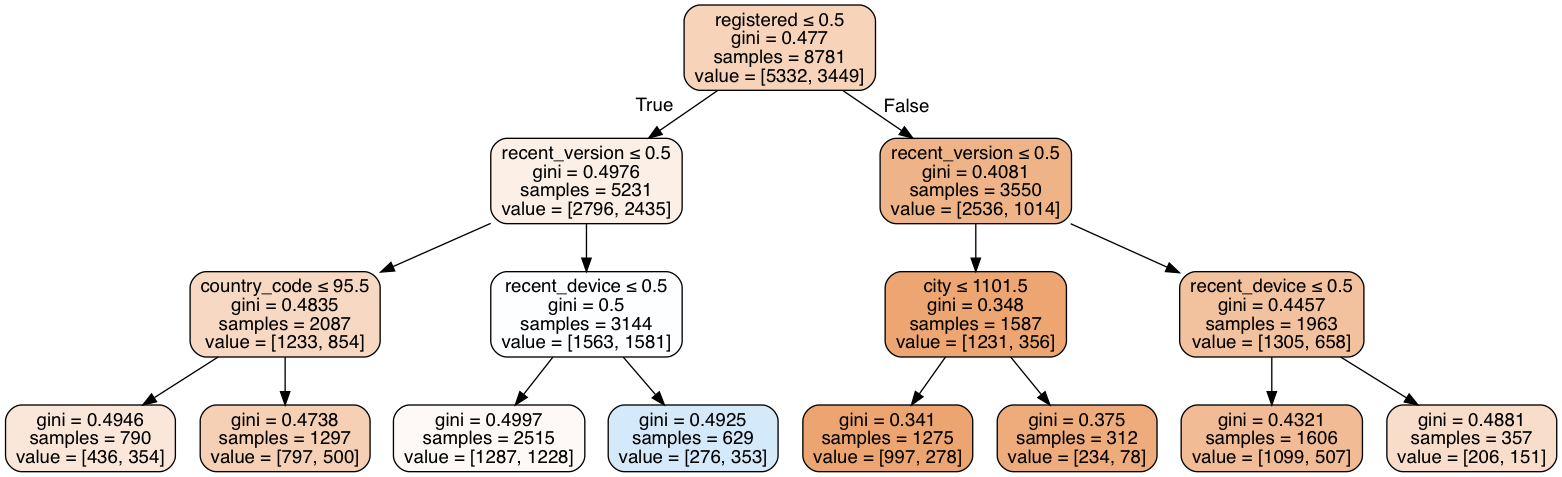

In [30]:
# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtr1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dt_model.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_fac.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### Findings:

From feature importance point of view, I am getting consistent results over both models. Decision tree is pretty much following the same prediction logic with logistic regression. Majority of the contributions for logistic regression is coming from the same 3 features. It is not surprising to see that the both model performances are very close.


## Random Forests

### Model

1. Gridsearch random forests for maximum depth, minimum samples per leaf (as before) and number of trees to grow. Random forests is high-performance, reduced variance alternative to decision trees. This comes with the cost of increased run-time.  
2. 5 fold cross validation, optimised for precision. 
3. Fit model and print best parameters, best precision score. 
4. Iterate process by refining parameter search space to find optimum values. 

In [31]:
def gridsearch_rf_model(params, X=X_fac):
    
    start = time.time()#start timer
    rf_model = RandomForestClassifier(random_state=42)#init model
    rf_grid = GridSearchCV(estimator=rf_model, param_grid=params, cv=5, scoring='precision')#8 fold cv, optimize for f1.
    rf_grid = rf_grid.fit(X_fac, y)#fit model
    end = time.time()#end timer
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", rf_grid.best_params_
    print 'Best precision score: \n', rf_grid.best_score_

    return rf_grid

In [32]:
params = {'n_estimators':[1, 5, 10, 50, 100],#number of trees
          'max_depth': [2, 10, 20, 50],#decision level depth 
          'min_samples_leaf': [1, 3, 5, 20, 50, 100]#min number of samples on final (decision) nodes - leaves.
         }

rf_grid = gridsearch_rf_model(params)

Model fit time in seconds: 
128.531286001
Best params: 
{'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 20}
Best precision score: 
0.654289714508


In [33]:
params = {'n_estimators':[80, 90, 100, 120, 180, 200],
          'max_depth': [2,3,4,10],
          'min_samples_leaf': [5,10,15,20,25,30,35,40]
         }

rf_grid = gridsearch_rf_model(params)

Model fit time in seconds: 
664.640910149
Best params: 
{'n_estimators': 80, 'max_depth': 2, 'min_samples_leaf': 25}
Best precision score: 
0.662404194925


In [34]:
model_scores(rf_grid, 'random forests', X=X_fac)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418
3,random forests,0.662411,0.0281248,0.61132


### Findings 

Random Forests outperforms both logistic regression and decision trees as expected. Best performance is achieved by generating large number of trees with few branches (small max depth). Since we are working with a small feature set with 5 columns this is normal. From feature importance observations earlier, there are only 3 features that are highly predictive. Random Forests achieve better performance by predicting through majority vote of large number of trees. It also reduces the variance by randomly assigning subset of features to branch splits.

It is also worth considering that improvement on precision comes with the price of deteriorated recall score. If the cost of false positives are higher than the value created by correctly predicting soon-to-churn users, random forests would be my pick. 

# K-Nearest Neighbors

In [35]:
print X.shape, y.shape#feature-target shapes for knn

(8781, 14) (8781,)


### Model

1. Gridsearch for number of neighbors. Test observation is assigned a class based on the majority class of its closest (euclidean distance) neighbors. Picking large number of neighbors would mean considering a large number of observations which might indicate lower bias. IT is easy to implement since there aren't many parameters search for.  It is also quite fast since it only considers a subset of neighboring points. As with Random Forests (hence decision tree), KNN is also a non-parametric model that does not assume a distribution for our data.
2. 5 fold cross validation, optimised for precision. 
3. Fit model and print best parameters, best precision score. 
4. Iterate process by refining parameter search space to find optimum values. 

In [36]:
def gridsearch_knn_model(params, X=X):

    start = time.time()#start timer
    knn_model = KNeighborsClassifier(n_jobs=4)#using all cores 
    knn_grid = GridSearchCV(estimator=knn_model, param_grid=params, cv=5, scoring='precision')#7 fold cross validation 
    knn_grid = knn_grid.fit(X, y)#fit model
    end = time.time()#stop timer
    print 'Model fit time in seconds: \n' + str(end-start)
    print "Best params: \n", knn_grid.best_params_
    print 'Best precision score: \n', knn_grid.best_score_

    return knn_grid

In [37]:
params = {'n_neighbors':[2, 5, 10, 50, 100, 1000]}

knn_grid = gridsearch_knn_model(params)

Model fit time in seconds: 
32.5820739269
Best params: 
{'n_neighbors': 1000}
Best precision score: 
0.544317672495


In [38]:
params = {'n_neighbors':[500, 800, 1000, 1300, 2000, 2500]}

knn_grid = gridsearch_knn_model(params)

Model fit time in seconds: 
158.473541975
Best params: 
{'n_neighbors': 2000}
Best precision score: 
0.582049238011


In [39]:
model_scores(knn_grid, 'k-nearest neighbors')

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418
3,random forests,0.662411,0.0281248,0.61132
4,k-nearest neighbors,0.582051,0.0223222,0.608587


Optimum performance is achieved through considering large number of neighbors. This increases the run-time a little but reduces bias as expected. Even though precision score is higher than logistic regression and decision tree, recall score is substantially lower. The model performs similar to random forests, but performs worse overall. Random forests is still the best model for now. 

# Principal Component Analysis

### K-Nearest Neighbors

KNN does not perform well with high dimensional data. Even though our feature set is not high dimensional (14 columns), it is still worth considering the effects of dimensionality reduction.

Dimensionality can be reduced by the transformation of feature space to obtain principal components that are not correlated to each other. Through sorting components by corresponding eigenvalues, we are able to identify components that accounts for the majority variance in our data. Dropping principal components with minor explained variances would be mostly removing noise, hence reducing dimensions.  

Even though the feature space is only boolean (single lambda value of 1), all values have to be centered in order to transform current axes. 

In [40]:
ss = StandardScaler()#Centering ((x-mean)/std) values for each column for PCA. 
Xss = ss.fit_transform(X)#fit and transform normalisation 
Xss = pd.DataFrame(Xss, columns=X.columns)#convert to df and keep column names
Xss.head(3)

,registered,recent_device,recent_version,city_bursa,city_istanbul,city_izmir,city_london,city_other,city_tokyo,country_code_JP,country_code_RU,country_code_TR,country_code_US,country_code_other
0,-0.823800,-0.427907,-1.178999,-0.1426,1.660536,-0.236198,-0.149115,-1.134599,-0.148715,-0.242053,-0.172591,0.956421,-0.299089,-0.609065
1,-0.823800,-0.427907,-1.178999,-0.1426,1.660536,-0.236198,-0.149115,-1.134599,-0.148715,-0.242053,-0.172591,0.956421,-0.299089,-0.609065
2,1.213887,-0.427907,0.848177,-0.1426,-0.602215,-0.236198,-0.149115,0.881369,-0.148715,-0.242053,-0.172591,-1.045565,3.343489,-0.609065


I will fit all the columns in feature matrix to PCA, visualise the explained ratio by each Principal Component and pick an appropriate cut-off threshold (number of pc's to keep). 

In [41]:
pca_model = PCA(n_components=len(X.columns)) #use all columns
pca_model = pca_model.fit(Xss.values)#fit PCA 

Plotting the cumulative sum of explained variances by each principal component is essential for easily identifying the number of columns to drop. It is important to note that Sklearn PCA library already returns the principal components sorted by their eigenvalues. 

In [42]:
def plot_cumsum_variance(var_ratio):
    """
    Plot cumulative sum of explained variance ratios by each principal component, starting from the 
    most dominant pc towards to least dominant pc. 
    """
    fig = plt.figure(figsize=(15,5))#init figure 
    ax = fig.gca()
    
    x_vals = range(1,len(var_ratio)+1)#set x&y values
    y_vals = var_ratio
    
    ax.set_title('Explained Variance over Principal Components')#set title and labels 
    ax.set_ylabel('Cumulative Sum of Variance Explained')
    ax.set_xlabel('Number of Principal Components')
    
    ax.plot(x_vals, y_vals)

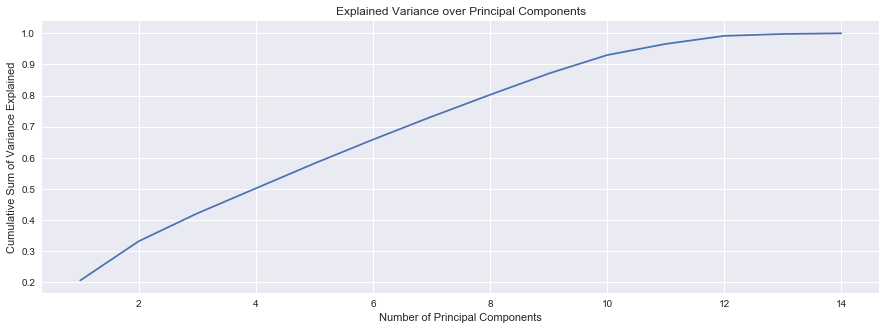

In [43]:
var_ratio = pca_model.explained_variance_ratio_
var_ratio = np.cumsum(var_ratio)#obtain cumulative sum for variance ratios 
plot_cumsum_variance(var_ratio)#plot results

Highest increase is from first pc to second pc, which indicates high information gain. The slope is then consistent until the 10'th pc. Pc's 11 and 12 adds less information than the previous ones. The final 2 pc's accounts for almost none of the variance in the data. Lets quantify these findings: 

In [44]:
print str(round(var_ratio[12],2)) + ' of variance in data is explained by the top 12 Principal Components' 

1.0 of variance in data is explained by the top 12 Principal Components


In [45]:
print str(round(var_ratio[10],2)) + ' of variance in data is explained by the top 10 Principal Components' 

0.97 of variance in data is explained by the top 10 Principal Components


In [46]:
print str(round(var_ratio[8],2)) + ' of variance in data is explained by the top 8 Principal Components' 

0.87 of variance in data is explained by the top 8 Principal Components


Lets transform centered values to obtain our observations in new feature space represented by principal components. 

In [47]:
Xpc = pca_model.transform(Xss.values)#projection to pcs
pd.DataFrame(Xpc).shape#projected shape

(8781, 14)

As stated earlier, there should be no correlation between the features. Lets validate by plotting the correlation heatmap:

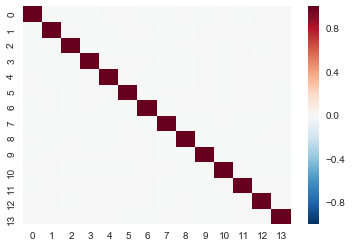

In [48]:
sns.heatmap(np.corrcoef(Xpc.T))#correlation heatmap of Principal Components 
plt.show()

#### Note: 

I have initially had 18 columns in my feature set. After plotting the correlation heatmap, I have observed that there were 4 columns that correlated with each other. Through inspection, I realised that drop_first parameter of pandas get_dummies function were set to false by default. These columns were redundant since all zeroes in other related categorical columns would indicate the same information. I have set the drop_first parameter to true in order to prevent redundant columns. 

In [49]:
Xpc = pd.DataFrame(Xpc, columns=['PC'+str(i) for i in range(1,len(Xpc[0])+1)])#convert to df
Xpc.head(3)#check results

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,2.119629,-0.284268,-0.492476,0.002351,-0.794245,0.817749,-0.223388,-1.010700,-0.479339,-0.604306,-0.227125,0.201526,-0.078801,-0.001979
1,2.119629,-0.284268,-0.492476,0.002351,-0.794245,0.817749,-0.223388,-1.010700,-0.479339,-0.604306,-0.227125,0.201526,-0.078801,-0.001979
2,-1.621400,-0.258894,2.120329,-1.641042,-0.531485,-0.853047,-0.268095,-0.845485,1.616374,1.357917,-0.455825,0.141435,0.019321,-0.031954


In [50]:
print Xpc.shape

(8781, 14)


Removing the last 4 columns, keeping 97% of variance. 

In [51]:
Xpc_10 = Xpc.ix[:,:'PC10']
print Xpc_10.shape

(8781, 10)


Through transformation of the feature space, we have re-arrenged the observation values. Re-optimisation is essential through gridsearch.

In [52]:
params = {'n_neighbors':[2, 5, 10, 50, 100, 1000]}

knn_pca_grid = gridsearch_knn_model(params, X=Xpc_10)

Model fit time in seconds: 
20.5278921127
Best params: 
{'n_neighbors': 50}
Best precision score: 
0.536500968029


In [53]:
params = {'n_neighbors':range(10,100,10)}

knn_pca_grid = gridsearch_knn_model(params, X=Xpc_10)

Model fit time in seconds: 
14.4053981304
Best params: 
{'n_neighbors': 60}
Best precision score: 
0.539222227791


In [54]:
model_scores(knn_pca_grid, 'knn -pc10', X=Xpc_10)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418
3,random forests,0.662411,0.0281248,0.61132
4,k-nearest neighbors,0.582051,0.0223222,0.608587
5,knn -pc10,0.53922,0.218351,0.618951


Compared to our initial KNN performance, the precision score has deteriorated, this might be due to information lost by dropping columns. The recall score has improved substantially, outperforming all other models so far. It is possible to keep all the information in the data by just dropping 2 columns. Lets see if we can keep high recall score while improving precision. 

Removing the last 2 columns, keeping 100% of variance, repeating gridsearch. 

In [55]:
Xpc_12 = Xpc.ix[:,:'PC12']

In [56]:
params = {'n_neighbors':[2, 5, 10, 50, 100, 1000]}

knn_pca_grid = gridsearch_knn_model(params, X=Xpc_12)

Model fit time in seconds: 
20.7510409355
Best params: 
{'n_neighbors': 50}
Best precision score: 
0.539506244644


In [57]:
params = {'n_neighbors':range(10,100,10)}

knn_pca_grid = gridsearch_knn_model(params, X=Xpc_12)

Model fit time in seconds: 
14.1481399536
Best params: 
{'n_neighbors': 60}
Best precision score: 
0.544362629091


In [58]:
model_scores(knn_pca_grid, 'knn -pc12', X=Xpc_12)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418
3,random forests,0.662411,0.0281248,0.61132
4,k-nearest neighbors,0.582051,0.0223222,0.608587
5,knn -pc10,0.53922,0.218351,0.618951
6,knn -pc12,0.544358,0.223568,0.619975


Precision score improved as expected. There is also an improvement in recall score. It seems like by transforming the feature space, using a feature set without any collinearity has made it easier for KNN to classify observations through their neighbors. This makes sense since the positions at each dimension are more distinct, hence more indicative.

This is a very important observation. We can make performance improvements for the remaining models. I am assuming PCA to mostly improve non-parametric models (random forests) due to the point stated above. In addition, I will not re-iterate this procedure for decision tree since random forests is a better model in any case. 

### Logistic Regression

Re-iterating gridsearch process with principal component feature space.

In [59]:
#Create a dictionary with the gridsearch parameters
params = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
          'penalty': ['l1','l2']}#searching over Lasso and Ridge

lr_pca_grid = gridsearch_lr_model(params, X=Xpc_12)

Model fit time in seconds: 
1.94265890121
Best params: 
{'penalty': 'l1', 'C': 0.01}
Best precision score: 
0.53822369317


In [60]:
params = {'C': np.linspace(0.005,0.015,15),
          'penalty': ['l1','l2']}

lr_grid = gridsearch_lr_model(params, X=Xpc_12)

Model fit time in seconds: 
2.62002110481
Best params: 
{'penalty': 'l1', 'C': 0.0050000000000000001}
Best precision score: 
0.545576994475


In [61]:
model_scores(lr_pca_grid, 'lr -pc12', X=Xpc_12)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418
3,random forests,0.662411,0.0281248,0.61132
4,k-nearest neighbors,0.582051,0.0223222,0.608587
5,knn -pc10,0.53922,0.218351,0.618951
6,knn -pc12,0.544358,0.223568,0.619975
7,lr -pc12,0.538229,0.167001,0.616104


There is a small deterioration in precision score and minor improvement on recall score. There is no substantial performance increase as expected. 

### Random Forests

Label encoded features (integers for categorical columns) will not work with PCA since the transformation will impose linear relationship between the numbers. I will use the dummy encoded categorical variables for PCA with Random Forests. Increasing dimensionality might also effect the performance of the model, interfering with the effect to be observed by the new feature space. 

In [62]:
params = {'n_estimators':[1,2,3,5,10,100],#number of trees
          'max_depth': [2, 10, 20, 50],#decision level depth 
          'min_samples_leaf': [1, 3, 5, 20, 50, 100]#min number of samples on final (decision) nodes - leaves.
         }

rf_pca_grid = gridsearch_rf_model(params, X=Xpc_12)

Model fit time in seconds: 
94.6691799164
Best params: 
{'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 20}
Best precision score: 
0.654289714508


In [63]:
params = {'n_estimators':range(50,150,10),
          'max_depth': [2,3,4,8,10],
          'min_samples_leaf': [5,10,15,20,25,30]
         }

rf_pca_grid = gridsearch_rf_model(params, X=Xpc_12)

Model fit time in seconds: 
794.644737959
Best params: 
{'n_estimators': 80, 'max_depth': 2, 'min_samples_leaf': 25}
Best precision score: 
0.662404194925


In [64]:
model_scores(rf_pca_grid, 'rf -pc12', X=Xpc_12)

,model,precision,recall,accuracy
0,baseline,NaN,NaN,0.60722
1,logistic regression,0.560111,0.128431,0.617015
2,decision tree,0.554243,0.107866,0.615418
3,random forests,0.662411,0.0281248,0.61132
4,k-nearest neighbors,0.582051,0.0223222,0.608587
5,knn -pc10,0.53922,0.218351,0.618951
6,knn -pc12,0.544358,0.223568,0.619975
7,lr -pc12,0.538229,0.167001,0.616104
8,rf -pc12,0.678,0.0179761,0.610978


Even though the the results table above shows minor precision score increse, final model fit output shows precision score identical to initial random forests. The difference in results may be due to variance in the model since I am running two seperate cross validation scoring (best score after fit, then in model_scores function). This invalidates my assumption that applying pca improves non-parametric models. Since the information inherent is data is still the same, performance doesn't change. 

# Evaluation & Tuning

Lets plot accuracy, precision and recall scores for each model used in modelling section. This will be a general overview of the performances we have obtained so far. 

In [65]:
def plot_model_perf(ax1_data, ax2_data):

    fig = plt.figure(figsize=(20,12))#init sub plots 
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    ax1 = sns.barplot(x='model', y='value', hue='variable', data=ax1_data, ax=ax1)#init bar plot for melted df
    ax1.set_title('Comparing Performances across Models')
    ax1.set_ylabel('Model Scores')
    ax1.set_xlabel('Models')

    ax2 = sns.barplot(x='model', y='value', hue='variable', data=ax2_data, ax=ax2)#same for pca applied results 
    ax2.set_title('Comparing Performances across PCA Applied Models')
    ax2.set_ylabel('Model Scores')
    ax2.set_xlabel('Models')

    plt.show()


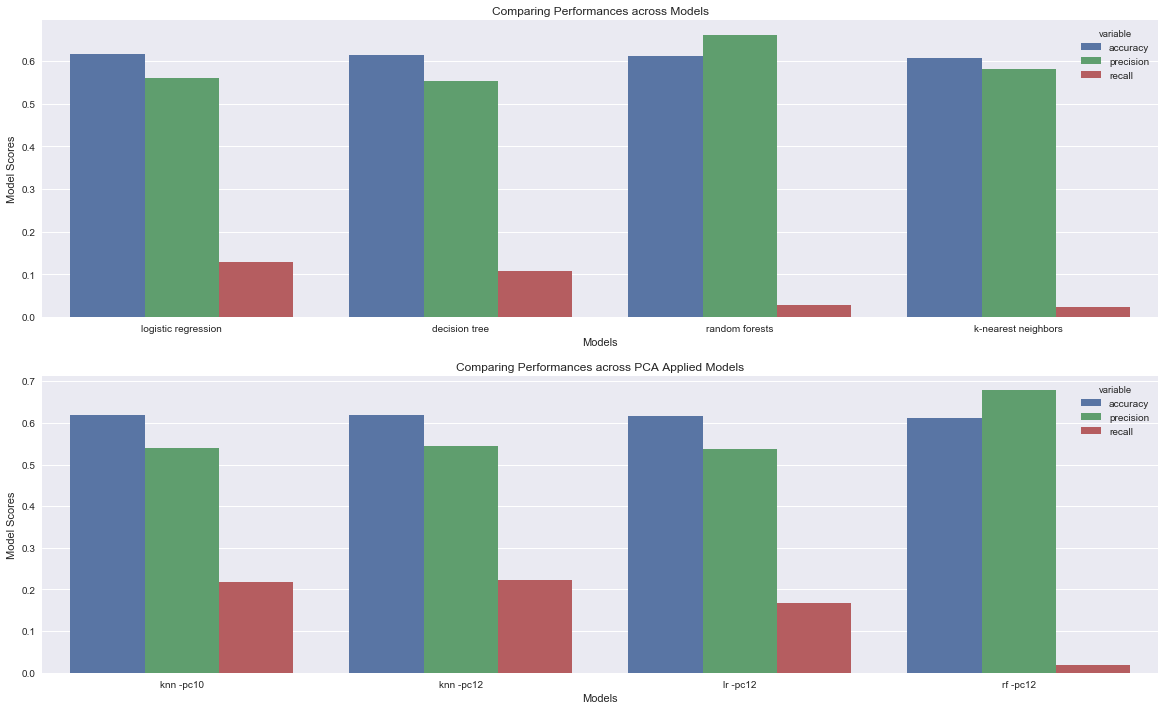

In [66]:
no_baseline = results[results['model'] != 'baseline']#remove baseline from results
no_baseline_normal = no_baseline.loc[:4,:]#initial results 
no_baseline_pca = no_baseline.loc[5:,:]#pca applied results

#melt dataframes for bar plotting 
results_melt_normal = pd.melt(no_baseline_normal, id_vars=['model'], value_vars=['accuracy','precision','recall'])#melt for plotting
results_melt_pca = pd.melt(no_baseline_pca, id_vars=['model'], value_vars=['accuracy','precision','recall'])#melt for plotting

plot_model_perf(results_melt_normal, results_melt_pca)

I will pick top 5 models and plot them independently.

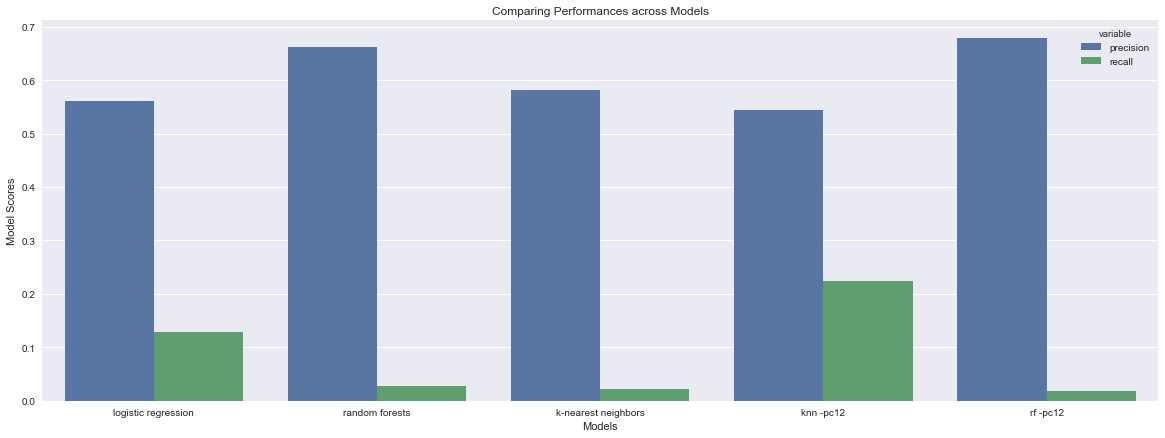

In [67]:
top_models = ['random forests','k-nearest neighbors','logistic regression','knn -pc12','rf -pc12']
top_results = no_baseline.loc[[1,3,4,6,8],:]
top_results_melt = pd.melt(top_results, id_vars=['model'], value_vars=['precision','recall'])

fig = plt.figure(figsize=(20,7))#init sub plots 
ax = fig.gca()

ax = sns.barplot(x='model', y='value', hue='variable', data=top_results_melt, ax=ax)#init bar plot for melted df
ax.set_title('Comparing Performances across Models')
ax.set_ylabel('Model Scores')
ax.set_xlabel('Models')

plt.show()

Random forests is clearly the highest performer in terms of precision. For the cases where recall is also important, KNN with pca would be the choice. However, if recall is equally imporant, we should re-optimise parameters with gridsearch setting scoring parameter to f1 (harmonic mean of precision and recall). Precision-recall curve will provide insight into performance potential of these models through modifying prediction thresholds.  

## Precision-Recall Curve

In [68]:
def plot_prauc(models):
    """
    Plot Precision-Recall Curve input models, showing Area Under the Curve on Legend.
    """
    fig, axr = plt.subplots(figsize=(20,7))#set figure
    
    return_dict = {}
    for i, model_tp in enumerate(models):
        y_pp, model_str = model_tp
        precision, recall, thrs = precision_recall_curve(y, y_pp)#precision-recall values over all thresholds 
        return_dict[model_str] = [precision, recall, thrs]    
        
        avg_precision = average_precision_score(y, y_pp)#average precision score for probabilities
        axr.plot(recall, precision, lw=1, label='%s (area = %0.2f)' % (model_str, avg_precision),#plot results
                 color='C'+str(i), linewidth=4,
                 alpha=0.7)

    axr.set_xlim([-0.05, 1.05])#set limits, labels, title
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('recall', fontsize=16)
    axr.set_ylabel('precision', fontsize=16)
    axr.set_title('Churn vs. not PRAUC curve\n', fontsize=20)

    axr.legend(loc="upper right", fontsize=12)#set legend

    plt.show()
    return return_dict

/Users/aligulez/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


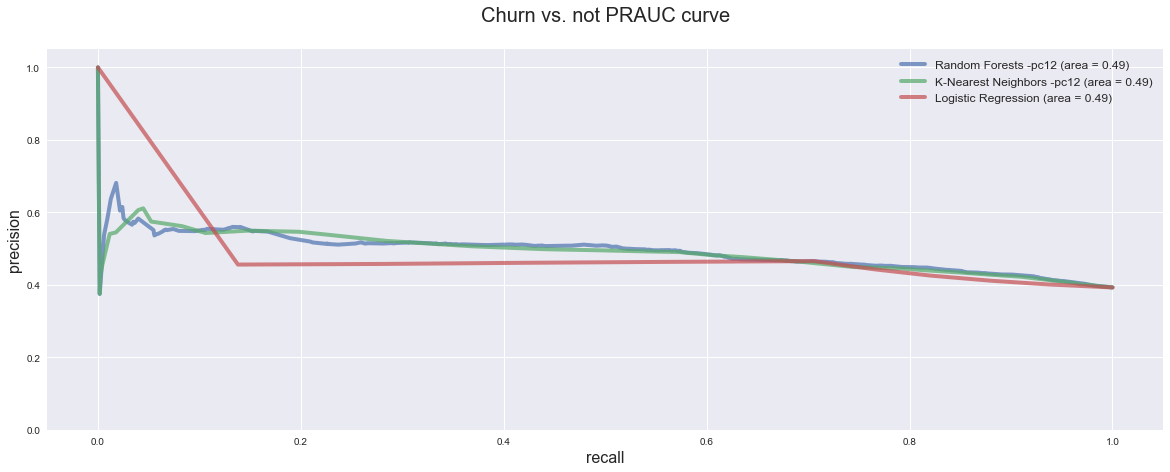

In [69]:
y_pp_rf = cross_val_predict(rf_pca_grid.best_estimator_, Xpc_12, y, cv=5, method='predict_proba')[:,1]
y_pp_knn = cross_val_predict(knn_pca_grid.best_estimator_, Xpc_12, y, cv=5, method='predict_proba')[:,1]
y_pp_lr = cross_val_predict(lr_grid.best_estimator_, X, y, cv=5, method='predict_proba')[:,1]

results_dict = plot_prauc([(y_pp_rf, 'Random Forests -pc12'), (y_pp_knn, 'K-Nearest Neighbors -pc12'), 
                           (y_pp_lr, 'Logistic Regression')])

#### Note: 

At first sight, it looks like logistic regression is better than the others for low recall values. However, through inspection, I have realised that there is only 10 threshold values plotted. Sklearn's precision_recall_curve function documentation indicates that the number of thresholds is equal or less than the total unique prediction probabilities. When I checked the logistic regression prediction probabilities, there is only 10 unique values. This makes sense because logistic regression had very high coefficients for only 3 features, mainly generalising the predictions. Since these features are boolean, logistic regression prediction probability is basically a combination of those 3 features multiplied by 1's or 0's, resulting in a few unique predictions. As a result, area under the curve is not accurate for logistic regression, there won't be any surprising over performance, I will rule out this model.

For recall scores below 10%, both models can provide higher than usual precision scores. After reaching the 10% recall mark, decline in precision slows down as recall increases. Area under the curve indicates that in general, precision-recall performance potential is the same for these models. However, best pick depends on the business outcome. Lets quantify results by checking the values at the peak of both model curves:

In [70]:
precision_, recall_, thresholds_ = results_dict['Random Forests -pc12']#read pr-curve results 
rf_prc = pd.DataFrame({'precision':precision_[:-1], 'recall':recall_[:-1], 'thresholds':thresholds_})#convert to df 
rf_prc[rf_prc.precision == np.max(rf_prc.precision)]#find max precision 

,precision,recall,thresholds
458,0.681319,0.017976,0.501726


In [71]:
precision_, recall_, thresholds_ = results_dict['K-Nearest Neighbors -pc12']#apply same for KNN 
rf_prc = pd.DataFrame({'precision':precision_[:-1], 'recall':recall_[:-1], 'thresholds':thresholds_})
rf_prc[rf_prc.precision == np.max(rf_prc.precision)]

,precision,recall,thresholds
27,0.611111,0.044651,0.616667


Initial results already provides the precision at 50% prediction threshold, therefore there is no improvement potential for random forests. However, by increasing the prediction threshold by 12% it is possible to reach 61% precision score with KNN, while having around 5% recall. 

## Conclusion

Lets assume that we have 1,000 users where 500 will churn. By using the recall formula (Tp/Tp+fn) KNN is able to correctly predict 22 users that will churn (true positives).  Since the precision is at 61% (Tp/Tp+Fp), there is a total of 35 users classified to churn, therefore 13 false positives. If we make the same calculation for random forests, the results would be 9 true positives and 4 false positives. Our pick depends on two main factors;

1. What is the proportion of misclassified users (FP's) that churns due to receiving an unexpected push notification. Obtaining this number would be very challening since we don't know if they would have already churned if they didn't receive the notification. Best approach would be to contact some of these users, talk to them about their experience and repeat this procedure until an acceptable p-value is achieved (less than 5%, not being very conservative for now). 
2. How much business value we are expecting to generate by preventing a user from churning, as well as how much business value we are expecting to destroy by losing a customer who wasn't going to churn in the first place. Obtaining this information is relatively easier, since it depends on the average revenue per user (ARPU). This value can also be improved by considering the lifetime cycle patters of users and calculating user lifetime value (LTV). 

The target is to build a low-maintenance push notification automation with minimal expenses, getting as close to bootstrapping as possible. A system that would leverage Amazon S3 in conjuction with Elastic Map Reduce, automated through a cronjob, pulling information from Mixpanel API on a daily basis. By this context, my solution to problems introduced above is to start with a small number of users with random forests (conservative) and measure the business value created/destroyed over time. Approaching the problem from A/B testing perspective, I am able to find guidance with minimal cost. 

# Understanding Churn 

The purpose of this section is to get actionable insights through observing feature importances. Once we are able understand what is causing churn, it is possible to redefine our product strategy and development roadmap. 

## Setup

In [73]:
people.head(3)

,city,country_code,registered,app_release,churn,recent_device,recent_version,acquisition_cohort
0,istanbul,TR,0,other,0,0,0,broad
1,istanbul,TR,0,other,1,0,0,broad
2,other,US,1,1.2,1,0,1,producthunt.com


For the purpose of predicting churn on day 1, I have dropped app release and acquisition cohort columns. In the context of understanding churn, these features will be useful. 

In [74]:
y2 = people.churn#target variable
X2 = people.drop('churn', axis=1)#drop time scale columns
X2 = pd.get_dummies(X2, columns=['city','country_code','app_release','acquisition_cohort'], drop_first=False)
#this time drop first is set to False since I want to see the coefficients for each column. 

In [75]:
print 'features shape: ' + str(X2.shape)
print 'target shape: ' + str(y2.shape)

features shape: (8781, 33)
target shape: (8781,)


## Correlation

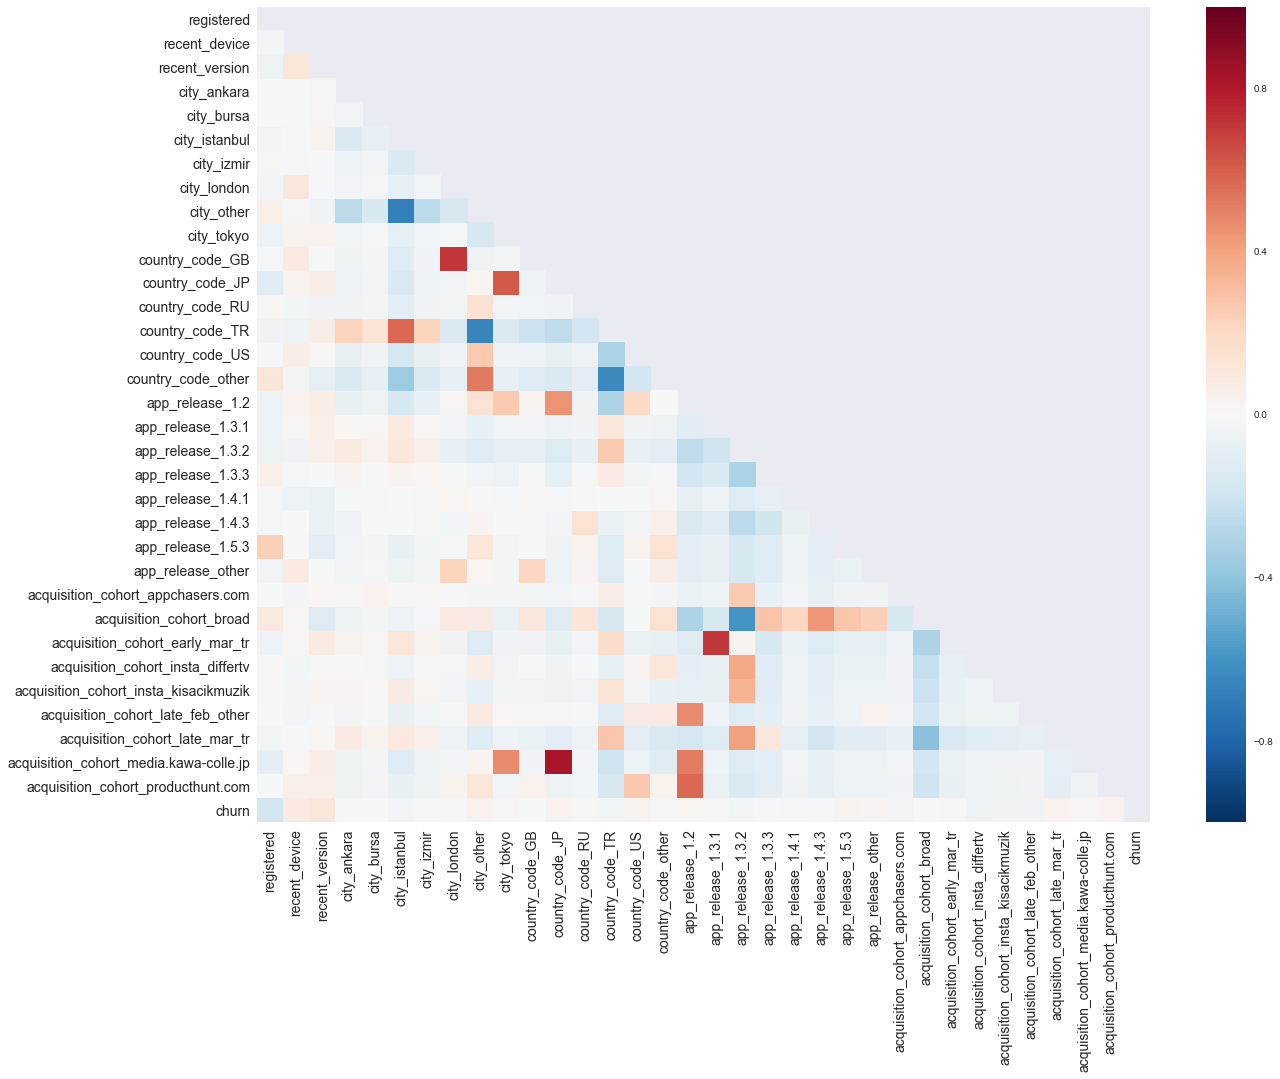

In [76]:
heatmap_data = X2.copy()
heatmap_data['churn'] = y2#add churn back to features 
corr_heatmap(heatmap_data, 20, 15)

Collinearities we have observed in the first section are the same, there is only the addition of app releases correlating with some acquisition cohorts. This makes sense because acquisition events took place during the times where some of the app releases were most recent. 

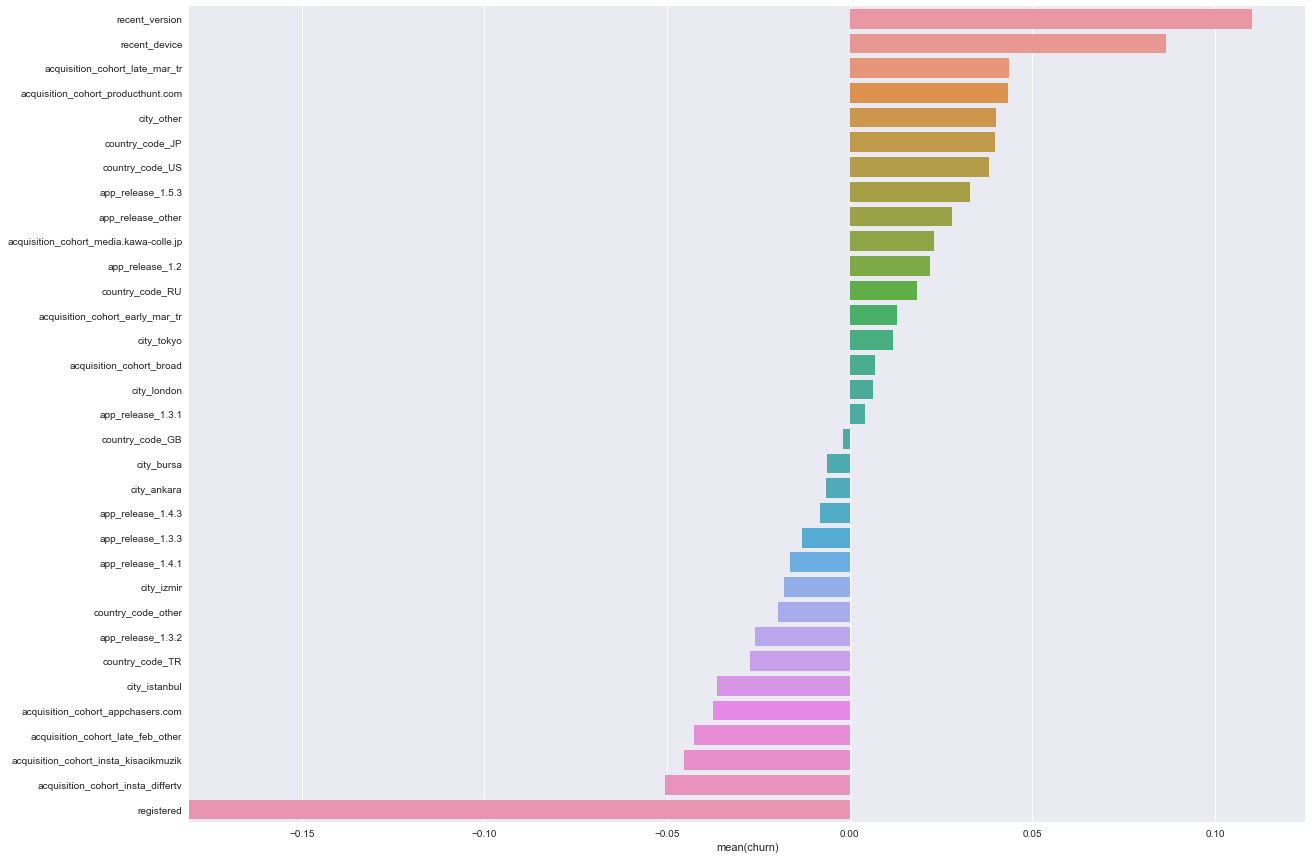

In [77]:
churn_corr = heatmap_data.corr()['churn'].drop('churn').sort_values(ascending=False)
plt.figure(figsize=(20,15))
sns.barplot(x=churn_corr, y=churn_corr.index)

As concluded before, registered, recent_device and recent_version have the highest correlation to churn. It is interesting to see some acquisition cohorts have higher correlation to churn than city and countries. Before jumping to any conclusion, lets fit a Lasso Regression model to see if feature coefficients agree with these results. 

## Lasso Regression

Lasso regularization takes into account collinearities and lack of variance in features, imposes individual penalties on variables depending on their contribution to final prediction residues. I will be using lasso regression to see if any of my feature variable coefficients are drawn to 0. I am also using accuracy optimisation with gridsearch since I am interested in balanced predictions for the sake of meaningful feature coefficients. 

In [78]:
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'penalty':['l1']#forcing lasso
         }

lr = LogisticRegression(random_state=42)
lr_gs = GridSearchCV(estimator=lr, param_grid=params, cv=5, scoring='accuracy')
lr_gs = lr_gs.fit(X2,y2)

In [79]:
print 'best params: \n' + str(lr_gs.best_params_)
print 'best accuracy: \n' + str(lr_gs.best_score_)

best params: 
{'penalty': 'l1', 'C': 1}
best accuracy: 
0.626807880651


Re-iterating fitting process in order to reach optimum parameter state. 

In [80]:
params = {'C':np.linspace(0.1,10,50),
          'penalty':['l1']#forcing lasso
         }

lr = LogisticRegression(random_state=42)
lr_gs = GridSearchCV(estimator=lr, param_grid=params, cv=5, scoring='accuracy')
lr_gs = lr_gs.fit(X2,y2)

In [81]:
print 'best params: \n' + str(lr_gs.best_params_)
print 'best accuracy: \n' + str(lr_gs.best_score_)

best params: 
{'penalty': 'l1', 'C': 1.716326530612245}
best accuracy: 
0.627491174126


Lets observe the feature coefficients. 

In [82]:
coefs_vars = pd.DataFrame({#dataframe for feature coeffs for easy plotting 
    'coef':lr_gs.best_estimator_.coef_[0],#feature coefficients
    'variable':X2.columns,#get names of the columns
    'abscoef':np.abs(lr_gs.best_estimator_.coef_[0])#absolute value feature coeffs. 
})
coefs_vars = coefs_vars.sort_values('abscoef', ascending=False)#sort by correlation strength 

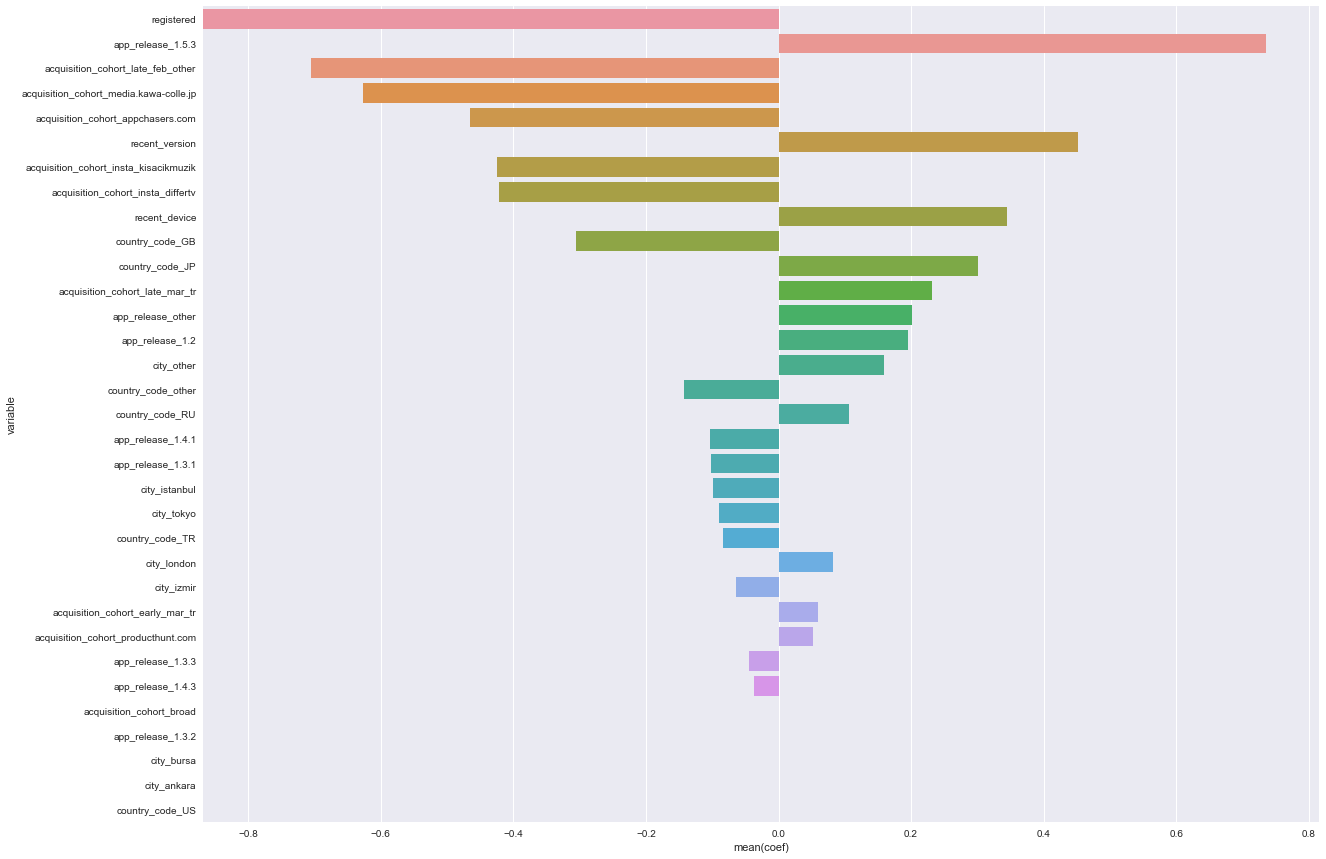

In [83]:
fig = plt.figure(figsize=(20,15))
sns.barplot(x='coef', y='variable', data=coefs_vars)

#### Note: 


Initially, when I plotted feature coefficients, I have observed a steady decrease in coefficients from first app release to final app release (1.5.3), starting from very high positive value with final release having very high negative coefficient. At first, it seemed like with each app release we have improved the user experiences reducing the chance of churn for each user. However, the reality was that the results were biased. Since the people dataset always keeps the information up to date, active users would always have the most recent releases. I have fixed this issue by finding the first 'App Launched' event from Events dataset for each user and assigning the app_release included in that JSON object. It turns out that actually, there could be an issue with our most recent app release, given its very high positive coefficient. 

## Conclusion

Lasso Regression coefficient explains a lot about the features that are indicative of churn. Analysing these values will guide us for strategising acquisition campaigns and product development roadmap. Below are the findings; 

1. We have observed that some acquisition cohorts and app releases had collinearity due to their dependance on date. Lasso results conlclude that acquisition cohorts are a better estimator for churn. This makes sense since it indicates the acquisition channel that is related to trust. 

2. Final release (app_release_1.5.3) has caused a lot of users to churn on day 1. This release has a major change that made registration to app mandatory. Our top 2 columns (registered and churn) is clearly showing that users who register would come back, while there is a group of users who would churn when they see the mandatory registration screen. Mandatory signup should be reconsidered from a product strategy perspective. 

3. Acquisition_cohort_broad coefficient is set to 0. This shows that users who don't belong to any acquisition event have varied intent, which is not predictive of churn. Some may be hearing the app from their friends, some may discover through the App Store. The marketing strategy is to always target a particular channel and measure the returns.  

4. Our initial finding of recent devices and ios versions (tech-savvy, high income users) are more likely to churn due to installing many apps and having less tolerance for retention. This information is very useful for targeted ads on platforms like Instagram and Facebook. 

5. Further investigation is needed for the acquisition event that took place in late February. If we can figure out which channel that they arrived from, it is possible to exploit it further for acquiring high value users. 

6. appchasers.com and media-kawa-colle.jp channels are quite good for advertisement, these are established brands where the readers trust their referrals. We should consider researching other publishers with similar user base and brand recognition. 




# Future Improvements

1. Compare training and test scores to see if any of the models are overfitting also plot variance cross validation test scores for each model. 
2. Plot performance increase over training data size, can we estimate how much the performance will increase over time as we acquire more users?
3. Feature engineering from Events dataset. I am expecting songs / playlists / number of songs / duration on first day activity to be highly correlated to churn. 
6. A/B Test push notifications (sending after 1 day, after 2 days, and so on.) for preventing churn and demonstrate results. 
5. Re-define churn as becoming inactive after 7 days, downsample data, pick new columns, clean and model. How does the accuracies change? 